This work is a Benchmark for comparing CNNs & RNNs using the same word embedding. I focused on the indicators below : 
* Performance (F1 / Precision / Recall)
* Training / Inference speed
* Model size

My work is inspired by and based on the following notebooks :
* [NLP (Disaster Tweets) with Glove and LSTM](https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm)
* [Tweet Analysis - ANN/BERT/CNN/n-gram CNN](https://www.kaggle.com/jagdmir/tweet-analysis-ann-bert-cnn-n-gram-cnn)

## 0 - Benchmark

| Model     | F1   | Precision | Recall | Training Time | Inference Time | Model Size |
|-----------|------|-----------|--------|---------------|----------------|------------|
| 1D CNN    | 0.78 | 0.73      | 0.83   | 10.9 s        | 0.1 ms         | 26.4 MB    |
| SimpleRNN | 0.76 | 0.69      | 0.85   | 57.3 s        | 0.5 ms         | 26.5 MB    |
| BiGRU     | 0.79 | 0.79      | 0.79   | 100.6 s       | 0.7 ms         | 27.1 MB    |
| BiLSTM    | 0.79 | 0.73      | 0.85   | 89.5 s        | 0.8 ms         | 27.4 MB    |

**This result is not completely stable yet, it can slightly change while executing. The parameters are not optimal either.** 

**However, we can still draw out two things :**

1. <span style="color:red">With fixed data and same pretrained embeddings, their performances are basically the same.</span>
2. <span style="color:red">CNN performes as well as RNNs while its training speed and inference speed are much faster.</span>

## 1 - Import

#### 1-1 - Libraries

In [1]:
# Basic
import os
import re
import time
import string

import warnings
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop = set(stopwords.words('english'))

# Machine Learning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

# Deep Learning
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, Bidirectional
from keras.layers import Embedding, BatchNormalization, Dense, TimeDistributed, Dropout, Flatten, GlobalMaxPool1D

Using TensorFlow backend.


#### 1-2 Data

In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test  = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

train_sent, test_sent, train_label = train.text.values, test.text.values, train.target.values

## 2 - Preprocessing

In [3]:
# Tokenization
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_sent)
vocab_length = len(word_tokenizer.word_index) + 1

In [4]:
def embed(corpus): return word_tokenizer.texts_to_sequences(corpus)

def metrics(y_true, y_pred):
    print("\nF1-score: ", round(f1_score(y_true, y_pred), 2))
    print("Precision: ", round(precision_score(y_true, y_pred), 2))
    print("Recall: ", round(recall_score(y_true, y_pred), 2))
    
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [5]:
# Padding sentences
longest_train = max(train_sent, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train)) # max_len = 31

padded_sentences = pad_sequences(embed(train_sent), length_long_sentence, padding='post')
test_sentences   = pad_sequences(embed(test_sent), length_long_sentence, padding='post')

In [6]:
%%time
# Import word vectors from GloVe
embeddings_dictionary = dict()
embedding_dim = 100

glove_file = open('../input/glove-file/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Convert sentences to embedding vectors
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector # embedding_matrix.shape = (16834, 100)

CPU times: user 27.5 s, sys: 760 ms, total: 28.2 s
Wall time: 30.5 s


In [7]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, 
                                                    train_label, 
                                                    test_size=0.25,
                                                    random_state=42, 
                                                    shuffle=True)
# X_train.shape, X_test.shape = ((5709, 31), (1904, 31))

## 3 - Modeling

In [8]:
def training(model, model_name):
    # Config
    checkpoint = ModelCheckpoint(model_name + '.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
    reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 5, min_lr = 0.001)
    early_stop = EarlyStopping(monitor='val_loss', patience=1)
    
    # Train
    start_time = time.time()
    history = model.fit(X_train, y_train, 
                        epochs = 100,
                        batch_size = 32,
                        validation_data = [X_test, y_test],
                        verbose = 1,
                        callbacks = [reduce_lr, checkpoint, early_stop])
    end_time = time.time()
    print("\n=>Training time :", round(end_time - start_time, 1), 's')

    # Validation
    model.load_weights(model_name + '.h5')
    start_time = time.time()
    preds = model.predict_classes(X_test)
    end_time = time.time()
    print('\n=>Average Inference Time :', round((end_time - start_time) / len(X_test) * 1000, 1), 'ms')
    print('\n=>Model Size :', round(os.stat(model_name + '.h5').st_size / (1024 ** 2), 1), 'MB')
    
    # Evaluation
    metrics(y_test, preds)
    plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

#### 3-1 1D CNN

In [9]:
def CNN():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = CNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 72, 100)           2270100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 32)            25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,305,993
Trainable params: 2,305,993
Non-trainable params: 0
____________________________________________

Train on 5709 samples, validate on 1904 samples
Epoch 1/100
5709/5709 [==============================] - 5s 897us/step - loss: 0.5009 - accuracy: 0.7604 - val_loss: 0.4215 - val_accuracy: 0.8204

Epoch 00001: val_loss improved from inf to 0.42149, saving model to model_cnn.h5
Epoch 2/100
5709/5709 [==============================] - 5s 829us/step - loss: 0.3477 - accuracy: 0.8530 - val_loss: 0.4204 - val_accuracy: 0.8188

Epoch 00002: val_loss improved from 0.42149 to 0.42036, saving model to model_cnn.h5
Epoch 3/100
5709/5709 [==============================] - 5s 873us/step - loss: 0.2381 - accuracy: 0.9080 - val_loss: 0.4750 - val_accuracy: 0.8246

Epoch 00003: val_loss did not improve from 0.42036

=>Training time : 15.7 s

=>Average Inference Time : 0.2 ms

=>Model Size : 26.4 MB

F1-score:  0.79
Precision:  0.8
Recall:  0.77


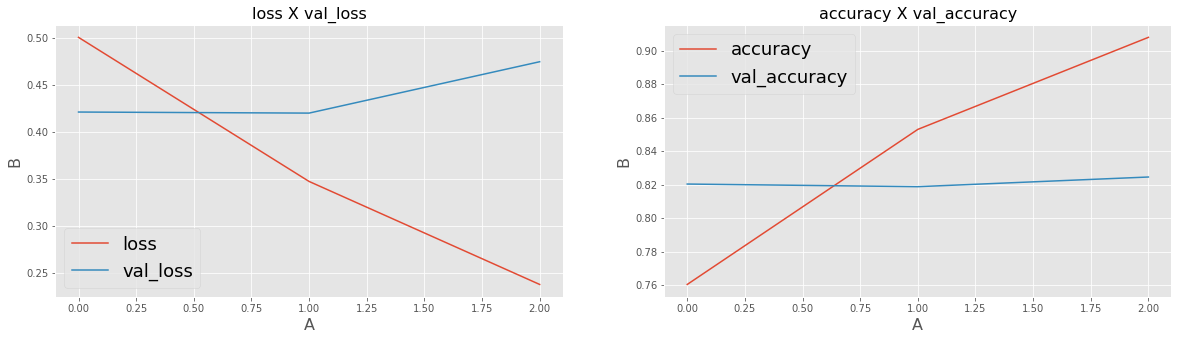

In [10]:
training(model, 'model_cnn')

#### 3-2 RNN

In [11]:
def RNN():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(SimpleRNN(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = RNN()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 72, 100)           2270100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 144)           24912     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 144)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 144)               576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 72)                10440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 72)               

Train on 5709 samples, validate on 1904 samples
Epoch 1/100
5709/5709 [==============================] - 14s 3ms/step - loss: 0.8142 - accuracy: 0.5621 - val_loss: 0.6712 - val_accuracy: 0.5425

Epoch 00001: val_loss improved from inf to 0.67117, saving model to model_rnn.h5
Epoch 2/100
5709/5709 [==============================] - 12s 2ms/step - loss: 0.6552 - accuracy: 0.6306 - val_loss: 0.6179 - val_accuracy: 0.7038

Epoch 00002: val_loss improved from 0.67117 to 0.61787, saving model to model_rnn.h5
Epoch 3/100
5709/5709 [==============================] - 12s 2ms/step - loss: 0.6092 - accuracy: 0.6856 - val_loss: 0.5182 - val_accuracy: 0.7920

Epoch 00003: val_loss improved from 0.61787 to 0.51822, saving model to model_rnn.h5
Epoch 4/100
5709/5709 [==============================] - 12s 2ms/step - loss: 0.5419 - accuracy: 0.7346 - val_loss: 0.4640 - val_accuracy: 0.8099

Epoch 00004: val_loss improved from 0.51822 to 0.46399, saving model to model_rnn.h5
Epoch 5/100
5709/5709 [=====

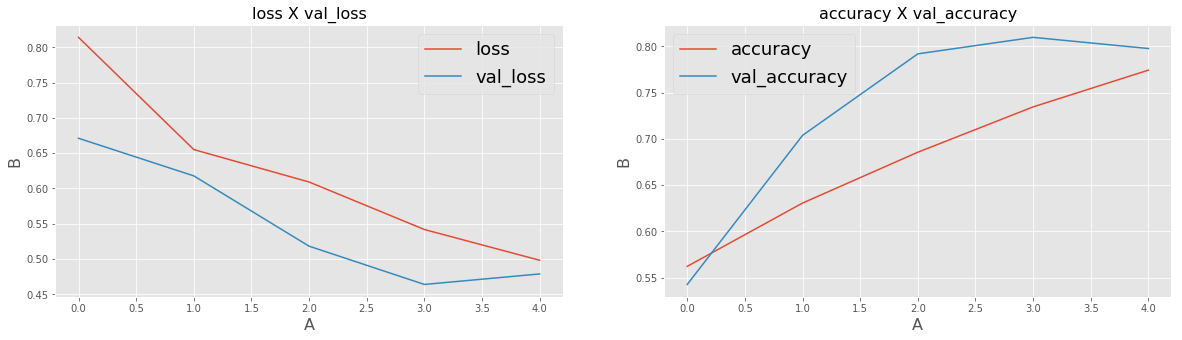

In [12]:
training(model, 'model_rnn')

#### 3-3 BiGRU

In [13]:
def BiGRU():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(GRU(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BiGRU()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 72, 100)           2270100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 72, 144)           74736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 144)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 144)               576       
_________________________________________________________________
dropout_4 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 72)                10440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 72)               

Train on 5709 samples, validate on 1904 samples
Epoch 1/100
5709/5709 [==============================] - 25s 4ms/step - loss: 0.6977 - accuracy: 0.6476 - val_loss: 0.6051 - val_accuracy: 0.8004

Epoch 00001: val_loss improved from inf to 0.60513, saving model to model_bigru.h5
Epoch 2/100
5709/5709 [==============================] - 23s 4ms/step - loss: 0.5308 - accuracy: 0.7441 - val_loss: 0.4983 - val_accuracy: 0.8146

Epoch 00002: val_loss improved from 0.60513 to 0.49829, saving model to model_bigru.h5
Epoch 3/100
5709/5709 [==============================] - 24s 4ms/step - loss: 0.4925 - accuracy: 0.7809 - val_loss: 0.4684 - val_accuracy: 0.8178

Epoch 00003: val_loss improved from 0.49829 to 0.46838, saving model to model_bigru.h5
Epoch 4/100
5709/5709 [==============================] - 24s 4ms/step - loss: 0.4452 - accuracy: 0.8099 - val_loss: 0.4604 - val_accuracy: 0.8225

Epoch 00004: val_loss improved from 0.46838 to 0.46041, saving model to model_bigru.h5
Epoch 5/100
5709/570

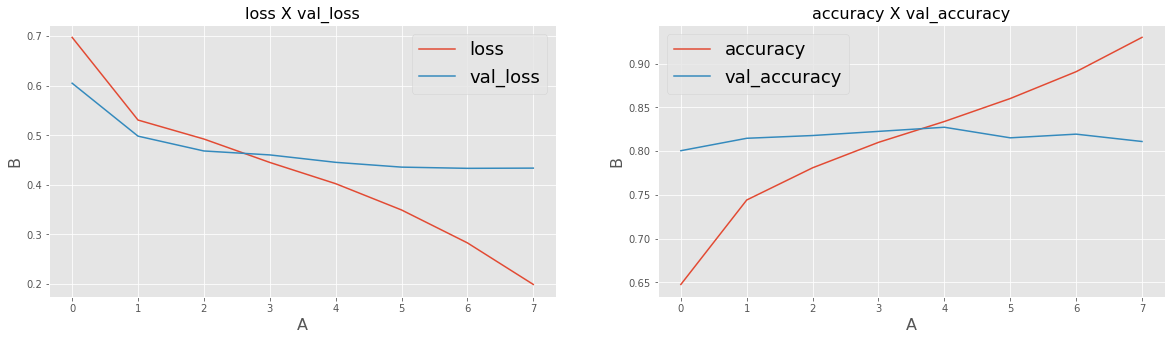

In [14]:
training(model, 'model_bigru')

#### 3-4 BiLSTM

In [15]:
def BiLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BiLSTM()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 72, 100)           2270100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 72, 144)           99648     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 144)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 144)               576       
_________________________________________________________________
dropout_7 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 72)                10440     
_________________________________________________________________
dropout_8 (Dropout)          (None, 72)               

Train on 5709 samples, validate on 1904 samples
Epoch 1/100
5709/5709 [==============================] - 24s 4ms/step - loss: 0.6994 - accuracy: 0.6560 - val_loss: 0.5939 - val_accuracy: 0.7957

Epoch 00001: val_loss improved from inf to 0.59388, saving model to model_bilstm.h5
Epoch 2/100
5709/5709 [==============================] - 20s 3ms/step - loss: 0.5237 - accuracy: 0.7576 - val_loss: 0.5084 - val_accuracy: 0.8272

Epoch 00002: val_loss improved from 0.59388 to 0.50844, saving model to model_bilstm.h5
Epoch 3/100
5709/5709 [==============================] - 20s 4ms/step - loss: 0.4647 - accuracy: 0.7987 - val_loss: 0.4273 - val_accuracy: 0.8335

Epoch 00003: val_loss improved from 0.50844 to 0.42726, saving model to model_bilstm.h5
Epoch 4/100
5709/5709 [==============================] - 19s 3ms/step - loss: 0.4144 - accuracy: 0.8264 - val_loss: 0.4201 - val_accuracy: 0.8262

Epoch 00004: val_loss improved from 0.42726 to 0.42013, saving model to model_bilstm.h5
Epoch 5/100
5709

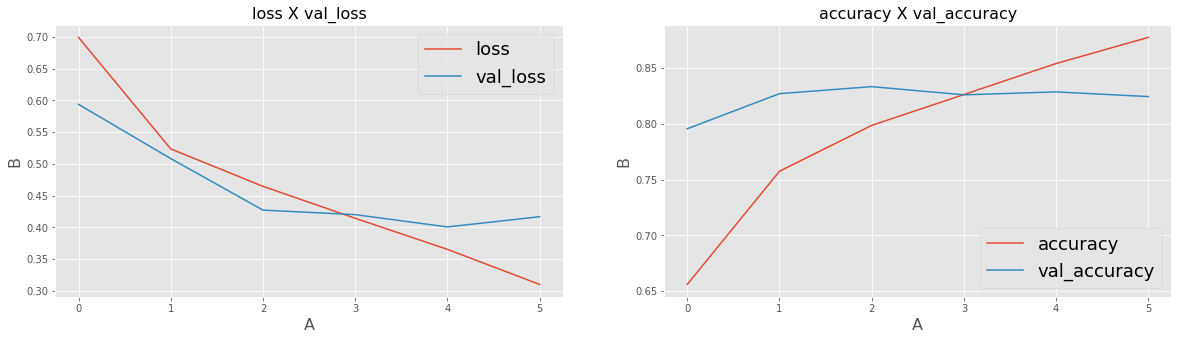

In [16]:
training(model, 'model_bilstm')

## 4 - Submission

In [17]:
submission.target = model.predict_classes(test_sentences)
submission.to_csv("submission.csv", index=False)